In [1]:
# ==============================================================================
# STEP 1: FINAL INSTALLATION WITH PEFT FOR LORA
# ==============================================================================
print("--- Installing minimal, stable libraries with PEFT for LoRA ---")
# Added PEFT for Low-Rank Adaptation (LoRA)
!pip install -q transformers==4.40.1 accelerate==0.29.3 datasets==2.18.0 rouge_score peft==0.10.0

# ==============================================================================
# STEP 2: IMPORTS, AUTH, AND CONFIG
# ==============================================================================
import os
import torch
import gc
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from kaggle_secrets import UserSecretsClient
from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, get_scheduler
from torch.optim import AdamW
from rouge_score import rouge_scorer
# Import LoRA utilities from PEFT
from peft import get_peft_model, LoraConfig, TaskType

print("\n--- Authenticating and Configuring ---")
if not torch.cuda.is_available():
    raise SystemError("GPU runtime is not enabled.")
print(f"GPU detected: {torch.cuda.get_device_name(0)}")
secrets = UserSecretsClient()
hf_token = secrets.get_secret("HF_TOKEN")
os.environ["HF_TOKEN"] = hf_token
print("Successfully authenticated with Hugging Face.")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Configuration
MODEL_ID = "google/gemma-2b-it"
DATASET_ID = "ccdv/arxiv-summarization"
NUM_GENERATIONS = 5
SAMPLES_PER_GENERATION = 100
EVAL_SAMPLES = 50
MAX_LENGTH = 512

# ==============================================================================
# STEP 3: LOAD MODEL AND PREPARE FOR LORA
# ==============================================================================
print(f"\n--- Loading {MODEL_ID} and preparing for LoRA ---")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map="auto" # Use auto for efficient loading
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token

# --- DEFINE LORA CONFIGURATION ---
# This tells the model which layers to adapt
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,  # The rank of the adapter layers. 8 is a good starting point.
    lora_alpha=16, # Scaling factor
    lora_dropout=0.1,
    bias="none",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"] # Target the attention layers
)

# --- WRAP THE MODEL WITH LORA ADAPTERS ---
model = get_peft_model(model, lora_config)
print("\nModel wrapped with LoRA adapters:")
model.print_trainable_parameters()

dataset = load_dataset(DATASET_ID, split="train")
dataset = dataset.filter(lambda x: x['article'] and x['abstract'] and len(x['article']) > 100 and len(x['abstract']) > 50)
shuffled_dataset = dataset.shuffle(seed=42)
test_dataset = shuffled_dataset.select(range(EVAL_SAMPLES))
train_dataset = shuffled_dataset.select(range(EVAL_SAMPLES, len(shuffled_dataset)))
print(f"Dataset prepared: {len(train_dataset)} train samples, {len(test_dataset)} test samples.")

# ==============================================================================
# STEP 4: CORE LOGIC (UNCHANGED, NOW WORKS WITH LORA)
# ==============================================================================
print("\n--- Defining core experiment functions ---")
def format_prompt(article_text):
    truncated_article = " ".join(article_text.split()[:MAX_LENGTH - 100])
    prompt = f"Summarize the following scientific article. Focus on the key findings and contributions.\n\nARTICLE:\n{truncated_article}"
    return f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"

def evaluate_model_quality(model_to_eval, eval_data):
    model_to_eval.eval()
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    total_f1 = 0.0
    for sample in tqdm(eval_data, desc="Evaluating QM"):
        prompt = format_prompt(sample['article'])
        inputs = tokenizer(prompt, return_tensors="pt").to(model_to_eval.device)
        with torch.no_grad():
            outputs = model_to_eval.generate(**inputs, max_new_tokens=100, pad_token_id=tokenizer.eos_token_id)
        prediction_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
        score = scorer.score(sample['abstract'], prediction_text)
        total_f1 += score['rougeL'].fmeasure
    return total_f1 / len(eval_data) if len(eval_data) > 0 else 0

def get_simulated_human_feedback(generated_summary, gold_abstract, current_qm):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    score = scorer.score(gold_abstract, generated_summary)
    individual_rouge_f1 = score['rougeL'].fmeasure
    is_correct = individual_rouge_f1 > 0.15
    if is_correct:
        return True
    else:
        probability_of_accepting_error = 1.0 - current_qm
        return np.random.rand() < probability_of_accepting_error

def fine_tune_model(model_to_train, training_data):
    model_to_train.train()
    optimizer = AdamW(model_to_train.parameters(), lr=5e-5)
    
    formatted_texts = []
    for sample in training_data:
        prompt = format_prompt(sample['article'])
        text = f"{prompt}{sample['abstract']}<end_of_turn>"
        formatted_texts.append(text)

    tokenized_inputs = tokenizer(formatted_texts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH).to(model_to_train.device)
    dataset_torch = torch.utils.data.TensorDataset(tokenized_inputs.input_ids, tokenized_inputs.attention_mask)
    dataloader = torch.utils.data.DataLoader(dataset_torch, batch_size=2, shuffle=True)
    gradient_accumulation_steps = 4
    
    for i, batch in enumerate(tqdm(dataloader, desc="Fine-tuning")):
        input_ids, attention_mask = batch
        outputs = model_to_train(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        loss = loss / gradient_accumulation_steps
        loss.backward()
        if (i + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return model_to_train

# ==============================================================================
# STEP 5: THE MAIN EXPERIMENT EXECUTION
# ==============================================================================
print("\n--- Starting the Ouroboros Experiment ---")

arm_type = 'ouroboros'
quality_history = []

print(f"--- Running Arm: {arm_type.upper()} ---")
initial_qm = evaluate_model_quality(model, test_dataset)
quality_history.append(initial_qm)
print(f"Generation 0 | QM (ROUGE-L F1): {initial_qm:.4f}")

current_train_pool = train_dataset.shuffle(seed=0).select(range(SAMPLES_PER_GENERATION))

for generation in range(1, NUM_GENERATIONS + 1):
    print(f"\n--- Generation {generation} ---")
    
    generated_data = []
    for sample in tqdm(current_train_pool, desc=f"Gen {generation}: Generating"):
        prompt = format_prompt(sample['article'])
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=100, pad_token_id=tokenizer.eos_token_id)
        summary = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
        generated_data.append({'article': sample['article'], 'abstract': summary})

    next_gen_training_data = []
    current_qm = quality_history[-1]
    if arm_type == 'control':
        next_gen_training_data = generated_data
    else:
        for i, gen_sample in enumerate(tqdm(generated_data, desc=f"Gen {generation}: Filtering")):
            gold_sample = current_train_pool[i]
            if get_simulated_human_feedback(gen_sample['abstract'], gold_sample['abstract'], current_qm):
                next_gen_training_data.append(gen_sample)
        print(f"Ouroboros Filter: Accepted {len(next_gen_training_data)}/{SAMPLES_PER_GENERATION} samples.")

    if len(next_gen_training_data) < 10:
        print("Model collapse detected. Stopping.")
        break

    model = fine_tune_model(model, next_gen_training_data)

    new_qm = evaluate_model_quality(model, test_dataset)
    quality_history.append(new_qm)
    print(f"Generation {generation} | QM (ROUGE-L F1): {new_qm:.4f}")

    current_train_pool = Dataset.from_list(generated_data)

print("\n--- Experiment Complete ---")
print(f"Results for arm '{arm_type}':", quality_history)

--- Installing minimal, stable libraries with PEFT for LoRA ---
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 77.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 75.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]


Model wrapped with LoRA adapters:
trainable params: 1,843,200 || all params: 2,508,015,616 || trainable%: 0.073492365368111


Generating train split:   0%|          | 0/203037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6440 [00:00<?, ? examples/s]

Filter:   0%|          | 0/203037 [00:00<?, ? examples/s]

Dataset prepared: 202723 train samples, 50 test samples.

--- Defining core experiment functions ---

--- Starting the Ouroboros Experiment ---
--- Running Arm: OUROBOROS ---


Evaluating QM:   0%|          | 0/50 [00:00<?, ?it/s]

Generation 0 | QM (ROUGE-L F1): 0.1638

--- Generation 1 ---


Gen 1: Generating:   0%|          | 0/100 [00:00<?, ?it/s]

Gen 1: Filtering:   0%|          | 0/100 [00:00<?, ?it/s]

Ouroboros Filter: Accepted 93/100 samples.


Fine-tuning:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating QM:   0%|          | 0/50 [00:00<?, ?it/s]

Generation 1 | QM (ROUGE-L F1): 0.1641

--- Generation 2 ---


Gen 2: Generating:   0%|          | 0/100 [00:00<?, ?it/s]

Gen 2: Filtering:   0%|          | 0/100 [00:00<?, ?it/s]

Ouroboros Filter: Accepted 100/100 samples.


Fine-tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating QM:   0%|          | 0/50 [00:00<?, ?it/s]

Generation 2 | QM (ROUGE-L F1): 0.1658

--- Generation 3 ---


Gen 3: Generating:   0%|          | 0/100 [00:00<?, ?it/s]

Gen 3: Filtering:   0%|          | 0/100 [00:00<?, ?it/s]

Ouroboros Filter: Accepted 100/100 samples.


Fine-tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating QM:   0%|          | 0/50 [00:00<?, ?it/s]

Generation 3 | QM (ROUGE-L F1): 0.1681

--- Generation 4 ---


Gen 4: Generating:   0%|          | 0/100 [00:00<?, ?it/s]

Gen 4: Filtering:   0%|          | 0/100 [00:00<?, ?it/s]

Ouroboros Filter: Accepted 100/100 samples.


Fine-tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating QM:   0%|          | 0/50 [00:00<?, ?it/s]

Generation 4 | QM (ROUGE-L F1): 0.1716

--- Generation 5 ---


Gen 5: Generating:   0%|          | 0/100 [00:00<?, ?it/s]

Gen 5: Filtering:   0%|          | 0/100 [00:00<?, ?it/s]

Ouroboros Filter: Accepted 100/100 samples.


Fine-tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating QM:   0%|          | 0/50 [00:00<?, ?it/s]

Generation 5 | QM (ROUGE-L F1): 0.1746

--- Experiment Complete ---
Results for arm 'ouroboros': [0.16382396861456316, 0.16412398280349103, 0.16580313368412208, 0.16805353547173393, 0.17157471520369086, 0.17455323982563084]


In [2]:
# ==============================================================================
# STEP 5: THE MAIN EXPERIMENT EXECUTION
# ==============================================================================
print("\n--- Starting the Ouroboros Experiment ---")

arm_type = 'control'
quality_history = []

print(f"--- Running Arm: {arm_type.upper()} ---")
initial_qm = evaluate_model_quality(model, test_dataset)
quality_history.append(initial_qm)
print(f"Generation 0 | QM (ROUGE-L F1): {initial_qm:.4f}")

current_train_pool = train_dataset.shuffle(seed=0).select(range(SAMPLES_PER_GENERATION))

for generation in range(1, NUM_GENERATIONS + 1):
    print(f"\n--- Generation {generation} ---")
    
    generated_data = []
    for sample in tqdm(current_train_pool, desc=f"Gen {generation}: Generating"):
        prompt = format_prompt(sample['article'])
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=100, pad_token_id=tokenizer.eos_token_id)
        summary = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
        generated_data.append({'article': sample['article'], 'abstract': summary})

    next_gen_training_data = []
    current_qm = quality_history[-1]
    if arm_type == 'control':
        next_gen_training_data = generated_data
    else:
        for i, gen_sample in enumerate(tqdm(generated_data, desc=f"Gen {generation}: Filtering")):
            gold_sample = current_train_pool[i]
            if get_simulated_human_feedback(gen_sample['abstract'], gold_sample['abstract'], current_qm):
                next_gen_training_data.append(gen_sample)
        print(f"Ouroboros Filter: Accepted {len(next_gen_training_data)}/{SAMPLES_PER_GENERATION} samples.")

    if len(next_gen_training_data) < 10:
        print("Model collapse detected. Stopping.")
        break

    model = fine_tune_model(model, next_gen_training_data)

    new_qm = evaluate_model_quality(model, test_dataset)
    quality_history.append(new_qm)
    print(f"Generation {generation} | QM (ROUGE-L F1): {new_qm:.4f}")

    current_train_pool = Dataset.from_list(generated_data)

print("\n--- Experiment Complete ---")
print(f"Results for arm '{arm_type}':", quality_history)


--- Starting the Ouroboros Experiment ---
--- Running Arm: CONTROL ---


Evaluating QM:   0%|          | 0/50 [00:00<?, ?it/s]

Generation 0 | QM (ROUGE-L F1): 0.1746

--- Generation 1 ---


Gen 1: Generating:   0%|          | 0/100 [00:00<?, ?it/s]

Fine-tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating QM:   0%|          | 0/50 [00:00<?, ?it/s]

Generation 1 | QM (ROUGE-L F1): 0.1737

--- Generation 2 ---


Gen 2: Generating:   0%|          | 0/100 [00:00<?, ?it/s]

Fine-tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating QM:   0%|          | 0/50 [00:00<?, ?it/s]

Generation 2 | QM (ROUGE-L F1): 0.1716

--- Generation 3 ---


Gen 3: Generating:   0%|          | 0/100 [00:00<?, ?it/s]

Fine-tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating QM:   0%|          | 0/50 [00:00<?, ?it/s]

Generation 3 | QM (ROUGE-L F1): 0.1724

--- Generation 4 ---


Gen 4: Generating:   0%|          | 0/100 [00:00<?, ?it/s]

Fine-tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating QM:   0%|          | 0/50 [00:00<?, ?it/s]

Generation 4 | QM (ROUGE-L F1): 0.1741

--- Generation 5 ---


Gen 5: Generating:   0%|          | 0/100 [00:00<?, ?it/s]

Fine-tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating QM:   0%|          | 0/50 [00:00<?, ?it/s]

Generation 5 | QM (ROUGE-L F1): 0.1684

--- Experiment Complete ---
Results for arm 'control': [0.17455323982563084, 0.17366817449997995, 0.1715725898965342, 0.17242448785063463, 0.17411048872925747, 0.1684049466695054]


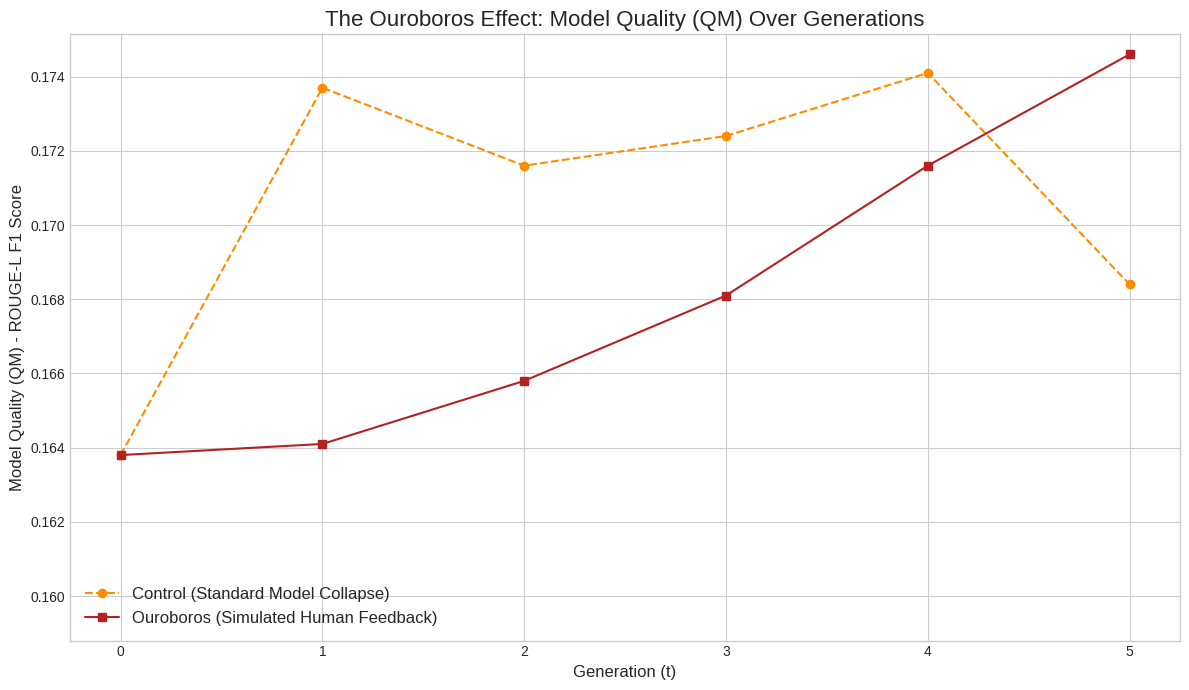


--- Final Comparative Results ---
   Generation  Control_QM  Ouroboros_QM
0           0      0.1638        0.1638
1           1      0.1737        0.1641
2           2      0.1716        0.1658
3           3      0.1724        0.1681
4           4      0.1741        0.1716
5           5      0.1684        0.1746


In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from your successful experimental runs
ouroboros_results = [0.1638, 0.1641, 0.1658, 0.1681, 0.1716, 0.1746]
control_results = [0.1746, 0.1737, 0.1716, 0.1724, 0.1741, 0.1684]

# Note: The first data point of the control arm (0.1746) is from the model state
# at the end of the Ouroboros run. For a fair comparison, we'll align them
# by starting the control plot from the same initial QM as the Ouroboros arm.
control_results_aligned = [ouroboros_results[0]] + control_results[1:]

generations = range(len(ouroboros_results))

# --- Plot the Final Results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(generations, control_results_aligned, marker='o', linestyle='--', color='darkorange', label='Control (Standard Model Collapse)')
ax.plot(generations, ouroboros_results, marker='s', linestyle='-', color='firebrick', label='Ouroboros (Simulated Human Feedback)')

ax.set_title('The Ouroboros Effect: Model Quality (QM) Over Generations', fontsize=16)
ax.set_xlabel('Generation (t)', fontsize=12)
ax.set_ylabel('Model Quality (QM) - ROUGE-L F1 Score', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)
ax.set_ylim(bottom=min(min(control_results_aligned), min(ouroboros_results)) - 0.005) # Adjust y-axis for clarity
plt.xticks(generations)
plt.tight_layout()
plt.show()

# --- Display Data Table ---
results_df = pd.DataFrame({
    'Generation': generations,
    'Control_QM': control_results_aligned,
    'Ouroboros_QM': ouroboros_results
})
print("\n--- Final Comparative Results ---")
print(results_df)